# Table of Contents
 <p><div class="lev1"><a href="#Import-libraries"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import libraries</a></div><div class="lev1"><a href="#Load-data-and-annotations"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data and annotations</a></div><div class="lev2"><a href="#Load-Homologene-mappings"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Load Homologene mappings</a></div><div class="lev2"><a href="#Load-cell-type-pattern-and-median-tables"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Load cell type pattern and median tables</a></div><div class="lev2"><a href="#Restrict-the-genes-to-the-one-that-have-a-clear-homologue"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Restrict the genes to the one that have a clear homologue</a></div><div class="lev1"><a href="#Filters"><span class="toc-item-num">3&nbsp;&nbsp;</span>Filters</a></div><div class="lev2"><a href="#Filter-the-binary-patterns-so-that-the-distance-is-useful"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Filter the binary patterns so that the distance is useful</a></div><div class="lev1"><a href="#Calculate-correlation"><span class="toc-item-num">4&nbsp;&nbsp;</span>Calculate correlation</a></div><div class="lev1"><a href="#Visualize-by-heat-map"><span class="toc-item-num">5&nbsp;&nbsp;</span>Visualize by heat map</a></div>

# Import libraries

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#imports
import pandas as pd
import cPickle as pickle
from scipy.spatial.distance import cdist, pdist, squareform

# Load data and annotations

## Load Homologene mappings

In [3]:
mouse2human_dict = pickle.load(open('data/Homologene_mouse2human_dict.pickle'))

## Load cell type pattern and median tables

In [4]:
pattern_df = pd.read_csv('data/Human_binary.tsv',sep='\t', index_col=0)
pattern_df_m = pd.read_csv('data/Mouse_binary.tsv',sep='\t', index_col=0)
median_df = pd.read_csv('data/Human_medians.tsv',sep='\t', index_col=0)
median_df_m = pd.read_csv('data/Mouse_medians.tsv',sep='\t', index_col=0)

## Restrict the genes to the one that have a clear homologue

In [5]:
# For easier handling convert the mouse name in the human name
mouse_translable = [i for i in pattern_df_m.index if i in mouse2human_dict]
pattern_df_m = pattern_df_m.ix[mouse_translable,:]
median_df_m = median_df_m.ix[mouse_translable,:]
pattern_df_m.index = [mouse2human_dict[i] for i in pattern_df_m.index]
median_df_m.index = [mouse2human_dict[i] for i in median_df_m.index]

In [6]:
# Take genes that have an homologue
common_genes = intersect1d(pattern_df_m.index, pattern_df.index)
pattern_df_m = pattern_df_m.ix[common_genes, :]
pattern_df = pattern_df.ix[common_genes, :]
median_df_m = median_df_m.ix[common_genes, :]
median_df = median_df.ix[common_genes, :]

# Filters

## Filter the binary patterns so that the distance is useful

In [7]:
# Exclude house-keeping and noisy genes genes
bool1 =  (pattern_df.ix[:,0] == 0)
print '%s are not significant as basal in human' % sum(bool1)
bool2 =  (pattern_df_m.ix[:,0] == 0)
print '%s are not significant as basal in mouse' % sum(bool2)
bool3 = (pattern_df.ix[:,1:].sum(1) > 0) & (pattern_df_m.ix[:,1:].sum(1) > 0) 
print '%s are significant in at least one cell type in both mouse and human' % sum(bool3)
bool4 = (pattern_df.ix[:,1:].sum(1) < 6) | (pattern_df_m.ix[:,1:].sum(1) < 6) 
print '%s are significant in less than 6 cell types type in either mouse or human' % sum(bool4)

# Exclude gene whose signal-to-noise ration is low
bool5 = (median_df.ix[:,1:].max(1) > 1.5) | (median_df_m.ix[:,1:].max(1) > 1.5) 
print '%s max median is more than 1.5 in either mouse or human' % sum(bool5)
bool6 = (median_df.ix[:,1:].min(1) < 0.25) | (median_df_m.ix[:,1:].min(1) < 0.25) 
print '%s min median is less than 0.25 in either mouse or human' % sum(bool6)

selected = (bool1 & bool2 & bool3 & bool4 & bool5 & bool6) 
print '%s satisfy all the conditions above' % sum(selected)

#Apply the filter
pattern_df_m = pattern_df_m.ix[selected,:]
pattern_df = pattern_df.ix[selected,:]
median_df_m = median_df_m.ix[selected,:]
median_df = median_df.ix[selected,:]

13100 are not significant as basal in human
12969 are not significant as basal in mouse
2805 are significant in at least one cell type in both mouse and human
13044 are significant in less than 6 cell types type in either mouse or human
5998 max median is more than 1.5 in either mouse or human
10261 min median is less than 0.25 in either mouse or human
1405 satisfy all the conditions above


# Calculate correlation

In [8]:
# These values were calculated in ipynb-lamanno2016-bayesGLM.ipynb here, for simplicity is just loaded
total_relative = array([1.   ,  1.257,  1.076,  0.973,  1.001, 1.085,  0.868,  1.237,  1.255,
                        1.056, 1.003,  0.887,  1.269,  0.868,  0.712, 0.847,  0.871,  0.788,
                        0.738,  0.641, 1.078,  0.826,  0.816,  0.703,  1.423,1.228])
total_relative__m = array([ 1.,  1.164,  0.852,  1.203,  0.935, 0.941,  1.019,  0.972, 0.927,  0.6496,
                           0.629,  0.908,  0.645,  0.692,  0.9322, 0.838,  0.781, 1.205,  1.025,
                             1.3181, 1.402,  0.875,  0.873,1.615,  1.3315, 1.450,  0.664])

In [9]:
# Normalize
median_df_m = (median_df_m/total_relative__m)
median_df = (median_df/ total_relative)
median_df_logn = log2(median_df+1).subtract( log2(median_df+1).mean(1), 'rows' )
median_df_m_logn = log2(median_df_m+1).subtract( log2(median_df_m+1).mean(1), 'rows' )

In [10]:
# Calculate Correlation
metric = 'correlation'
D = 1-cdist(median_df_m.ix[:,1:].T, median_df.ix[:,1:].T, metric) # this is faster and equivalent at np.corrcoeff

# Visualize by heat map

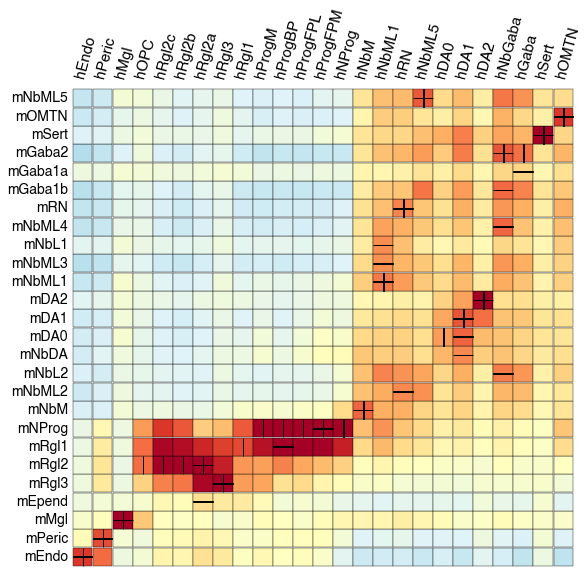

In [11]:
# the code below just takes D and plots it
rcParams['pdf.fonttype'] = 42
figure(figsize=(5,5))

hh = 0.02
ww = 0.065
color_name = 'RdYlBu_r'
for i, ct_x in enumerate( median_df_logn.columns[1:] ):
    for j, ct_y in enumerate( median_df_m_logn.columns[1:] ):
        colorvalue =   clip( (D[j,i] + 0.425) / 0.85 ,0,1)
        colormap = plt.cm.get_cmap(color_name)
        edc = '0.02'
        lww = 0.4
        zzor = -1
        gca().add_patch(Rectangle((i*ww,j*hh),0.98*ww,0.99*hh,ec=edc,lw=lww,\
                                  fc=colormap(colorvalue),clip_on=0, zorder=zzor))
        
        # It adds horizontal and vertical lines to the max horizontal of row- and columns-wise respectivelly
        if D[j,i]==max(D[j,:]):
            gca().add_patch(Rectangle((i*ww,(j+0.485)*hh),0.98*ww,0.03*hh,ec=edc,lw=1,\
                                  fc='none',clip_on=0, zorder=1000))
        if D[j,i]==max(D[:,i]):
            gca().add_patch(Rectangle(((i+0.485)*ww,j*hh),0.03*ww,0.99*hh,ec=edc,lw=1,\
                                  fc='none',clip_on=0, zorder=1000))   

for j, ct_y in enumerate( median_df_m.columns[1:] ):
    gca().text(-ww+0.05,hh*(j+0.5), ct_y,\
               fontdict={'fontsize':14}, va='center', ha='right')
for i, ct_x in enumerate( median_df_logn.columns[1:]):
    gca().text(ww*(i+0.5)-0.03,hh*len(median_df_m.columns[1:])+0.01,ct_x,\
               fontdict={'fontsize':15}, va='bottom', ha='left',rotation=75)
axis('off')
ylim(0.,0.35)
tight_layout()